Importing all required libraries

In [19]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import cv2 
import os 
import xml.etree.ElementTree as ET 
from PIL import Image 
from pathlib import Path 
import random 
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
images_dir = r'C:\Users\V Varunkumar\Desktop\programming assignment 2\images' 
annotation_dir = r'C:\Users\V Varunkumar\Desktop\programming assignment 2\annotation''

In [21]:
# Function to List directories inside a given path 
def list_directories (path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))] 

In [22]:
images_subdirs = list_directories (images_dir) 
annotations_subdirs = list_directories (annotation_dir)

1. Use images from ALL FOUR classes.

In [23]:
print("Directories in Images folder:", images_subdirs) 
print("\nDirectories in Annotations folder:", annotations_subdirs)

Directories in Images folder: ['n02091831-Saluki', 'n02093859-Kerry_blue_terrier', 'n02108551-Tibetan_mastiff', 'n02111277-Newfoundland']

Directories in Annotations folder: ['n02091831-Saluki', 'n02093859-Kerry_blue_terrier', 'n02108551-Tibetan_mastiff', 'n02111277-Newfoundland']


In [24]:
import os
from skimage import filters, exposure
from skimage.color import rgb2gray
from skimage.io import imread
import numpy as np

def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

def compute_edge_histogram(image, grid_size=(4, 4), nbins=36):
    """Compute the edge histogram for an image."""
    # Convert to grayscale
    gray_img = rgb2gray(image)

    # Get the Sobel gradients
    dx = filters.sobel_h(gray_img)
    dy = filters.sobel_v(gray_img)

    # Compute the gradient angle
    angle_sobel = angle(dx, dy)

    # Divide the image into sub-regions and compute histograms for each region
    height, width = gray_img.shape
    h_step = height // grid_size[0]
    w_step = width // grid_size[1]

    edge_hist = []

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Extract sub-region
            sub_region = angle_sobel[i*h_step:(i+1)*h_step, j*w_step:(j+1)*w_step]

            # Compute histogram for the sub-region
            hist, _ = exposure.histogram(sub_region, nbins=nbins)

            # Normalize histogram
            hist = hist / hist.sum()

            # Append to the edge histogram
            edge_hist.extend(hist)

    return edge_hist



2. Convert the images to edge histograms. (Assignment 1 - These will be the vector representations of the
images). This will be your dataset for Part 3.

In [25]:
# Main code to process all images in the directory
histograms = []
labels = []

for index, name in enumerate(os.listdir(images_dir)):
    label = []
    for image in os.listdir(os.path.join(images_dir, name)):
        img = imread(os.path.join(images_dir, name, image.strip()))

        # Compute the edge histogram
        edge_hist = compute_edge_histogram(img, grid_size=(4, 4), nbins=36)

        # Append histogram and label
        histograms.append(edge_hist)
        labels.append(index)

# Convert histograms and labels to arrays for further processing
histograms = np.array(histograms)
labels = np.array(labels)
        

In [26]:
histograms.shape

(726, 576)

3. Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20

In [27]:
# Convert the list of histograms and labels to numpy arrays for further processing
X = histograms  # Features (edge histograms)
y = labels      # Labels (corresponding class indices)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)



4. Perform standardization on the training dataset.

In [28]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_standardized = scaler.fit_transform(X_train)



# Output the results to verify
print("Standardization complete.")
print(f"Mean of standardized training data: {np.mean(X_train_standardized, axis=0)}")
print(f"Variance of standardized training data: {np.var(X_train_standardized, axis=0)}")


Standardization complete.
Mean of standardized training data: [-7.01067556e-16  2.54987602e-15 -5.83830159e-16 -4.06140638e-15
  5.95500660e-16  3.79562282e-15  3.46657569e-16  1.78248221e-15
  6.12919677e-16  4.29541460e-16  5.98754762e-16  4.53621814e-15
  4.65527999e-16  2.83202580e-15 -8.06251617e-16 -3.11340991e-16
  1.56943424e-15  8.61667060e-16  3.46753277e-16  1.17051962e-16
 -4.18056394e-16 -9.28950403e-16  7.04991621e-16  4.26191649e-15
  8.89709762e-16  2.97597196e-15  1.57833516e-15  2.27059750e-15
 -1.20239068e-15  1.89541869e-15  1.02944473e-15 -2.89653359e-15
 -7.45380769e-16 -1.43659031e-16  8.99854903e-16  3.48188911e-16
 -1.66533454e-17  1.63164501e-15 -1.76903511e-15  9.50006357e-16
  1.48296126e-15  1.56196894e-15 -3.43116340e-15 -1.52777695e-15
 -5.51005601e-15  2.33395678e-15 -3.09139687e-16  1.63495893e-15
  3.86453321e-15 -2.49082364e-15 -1.88278512e-15 -2.50271547e-15
 -3.68664629e-16  2.22934698e-15  1.69605709e-15 -6.79317713e-16
  3.27514596e-15 -4.20066281

5. Perform standardization on the test dataset using the means and variances you obtained from the training dataset.

In [29]:
# Use the mean and variance from the training data to transform the test data
X_test_standardized = scaler.transform(X_test)


In [30]:
from sklearn.model_selection import StratifiedKFold

# Initialize stratified 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


6. Perform stratified 5-fold cross-validation on the 4-class classification problem
using the three classification methods (available on canvas) assigned to you.

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Network": MLPClassifier(max_iter=10000),
    "AdaBoost": AdaBoostClassifier(n_estimators=1000)
}

Plot the (3) confusion matrices for using three approaches (clearly label the classes) on the test set

### References
Classification Report for Prediction
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html

Confusion matrices for classification
https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html



DecisionTreeClassifier()


              precision    recall  f1-score   support

           0       0.31      0.30      0.30        40
           1       0.40      0.44      0.42        36
           2       0.19      0.16      0.17        31
           3       0.35      0.36      0.35        39

    accuracy                           0.32       146
   macro avg       0.31      0.32      0.31       146
weighted avg       0.32      0.32      0.32       146

Mean validation acc: 0.3443268776570618


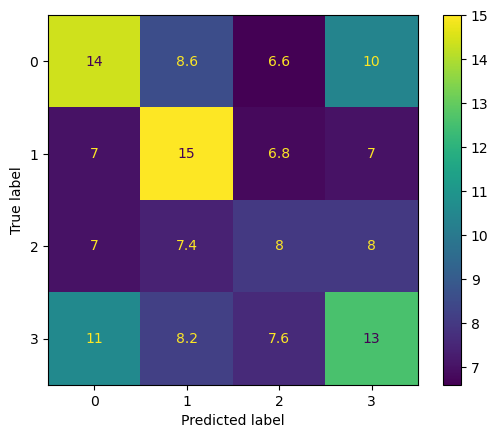

MLPClassifier(max_iter=10000)


              precision    recall  f1-score   support

           0       0.57      0.72      0.64        40
           1       0.54      0.53      0.54        36
           2       0.45      0.29      0.35        31
           3       0.42      0.44      0.43        39

    accuracy                           0.51       146
   macro avg       0.50      0.49      0.49       146
weighted avg       0.50      0.51      0.50       146

Mean validation acc: 0.40775625885687294


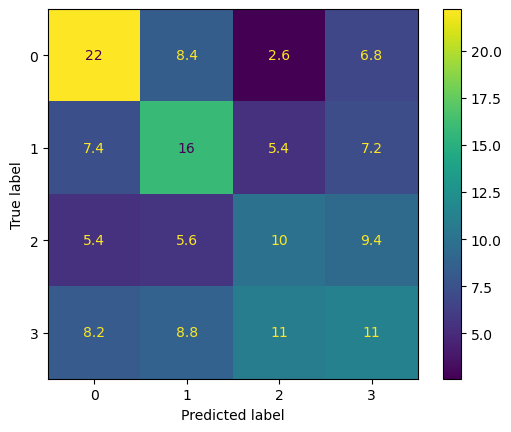

AdaBoostClassifier(n_estimators=1000)


              precision    recall  f1-score   support

           0       0.59      0.42      0.49        40
           1       0.63      0.61      0.62        36
           2       0.27      0.13      0.17        31
           3       0.34      0.59      0.43        39

    accuracy                           0.45       146
   macro avg       0.46      0.44      0.43       146
weighted avg       0.46      0.45      0.44       146

Mean validation acc: 0.410533774208786


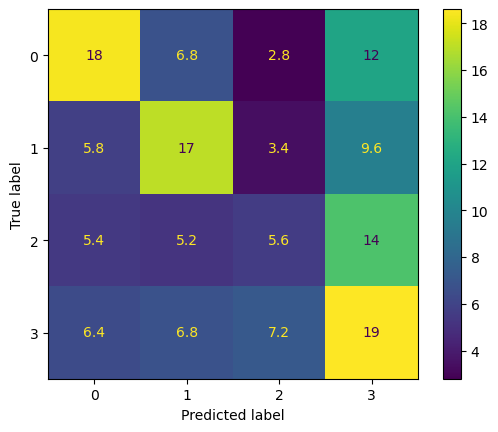

In [32]:
from sklearn import metrics 

for clf in classifiers.values(): 
    print(str(clf)+"\n\n") 
    clf.fit(X_train_standardized,y_train) 
    predictions=clf.predict(X_test_standardized) 
    confusion_matrix = metrics.confusion_matrix(y_test, predictions) 
    report=metrics.classification_report(y_test, predictions) 
    print(report) 
    truelabels, predictlabels, cm, val_a=[], [], [], [] 
    for traini, testi in kfold.split(X,y): 
        xtrain, xtest=X[traini], X[testi] 
        ytrain, ytest=y[traini], y[testi] 

        clf.fit(xtrain, ytrain) 
        p=clf.predict(xtest) 

        truelabels.extend(ytest) 
        predictlabels.extend(p) 
        val_a.append(metrics.accuracy_score (ytest,p)) 
        cm.append(metrics.confusion_matrix(ytest,p)) 
    print("Mean validation acc: "+str(np.mean(val_a))) 
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = sum(cm)/len(cm)) 
    cm_display.plot() 
    plt.show()

1. The MLPClassifier confusion matrix performs best, showing the highest diagonal values indicating correct predictions across classes, with fewer misclassifications than the first and slightly better than the third.
2. Best Method According to Mean Validation Accuracy
 The mean validation accuracies for the three methods are:
Decision Tree: 0.3319
AdaBoost: 0.4105
Neural Network (MLP): 0.4174
The highest mean validation accuracy is achieved by MLPClassifier (Neural Network) with a mean accuracy of 0.4174. Hence, the MLPClassifier is the best method based on mean validation accuracy.

3. Best Method According to Test Set Accuracy
The test set accuracies for the three methods are:

Decision Tree: 0.35
AdaBoost: 0.45
Neural Network (MLP): 0.49
The highest test set accuracy is achieved by MLPClassifier (0.49). Therefore, MLPClassifier is also the best method based on test set accuracy.

4. Best Method According to F-Measure
Comparing the weighted average F-measures on the test set:

Decision Tree: 0.35
AdaBoost: 0.44
Neural Network (MLP): 0.49
The MLPClassifier again has the highest weighted average F-measure (0.49). Thus, it is the best method according to the F-measure on the test set.

### Use images from TWO classes.

In [33]:
all_classes = os.listdir(images_dir)
selected_classes = random.sample(all_classes, 2)  # Randomly select 2 classes

# Initialize lists for histograms and labels
sel_histograms = []
sel_labels = []

# Process only the selected classes
for index, class_name in enumerate(selected_classes):
    class_dir = os.path.join(images_dir, class_name)
    for image_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, image_name)
        img = imread(img_path)

        # Compute the edge histogram
        edge_hist = compute_edge_histogram(img, grid_size=(4, 4), nbins=36)

        # Append histogram and label
        sel_histograms.append(edge_hist)
        sel_labels.append(index)  # Label as 0 or 1 based on the selected class

# Convert histograms and labels to arrays for further processing
selected_classes_histograms = np.array(sel_histograms)
selected_classes_labels = np.array(sel_labels)

In [34]:
Selected_X = selected_classes_histograms
Selected_Y = selected_classes_labels

In [35]:
selected_X_train, selected_X_test, selected_y_train, selected_y_test = train_test_split(
    Selected_X, Selected_Y, test_size=0.2, random_state=42)

Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation on the training set

In [36]:
# Initialize the StandardScaler
Selected_scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
selected_X_train_standardized = Selected_scaler.fit_transform(selected_X_train)

In [37]:
# Use the mean and variance from the training data to transform the test data
selected_X_test_standardized = scaler.transform(selected_X_test)

# Initialize stratified 5-fold cross-validation
selected_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

DecisionTreeClassifier()


              precision    recall  f1-score   support

           0       0.72      0.65      0.68        43
           1       0.58      0.66      0.62        32

    accuracy                           0.65        75
   macro avg       0.65      0.65      0.65        75
weighted avg       0.66      0.65      0.66        75

Mean validation acc: 0.3360415682569674


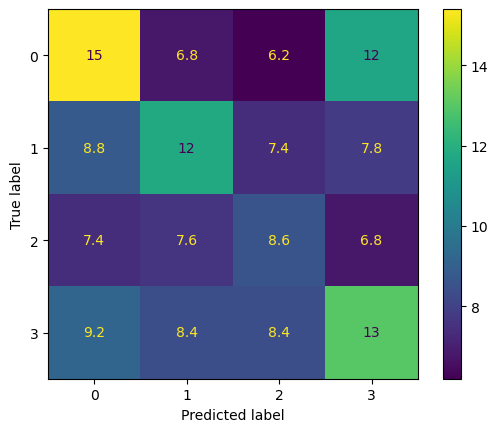

MLPClassifier(max_iter=10000)


              precision    recall  f1-score   support

           0       0.73      0.70      0.71        43
           1       0.62      0.66      0.64        32

    accuracy                           0.68        75
   macro avg       0.67      0.68      0.68        75
weighted avg       0.68      0.68      0.68        75

Mean validation acc: 0.3981105337742088


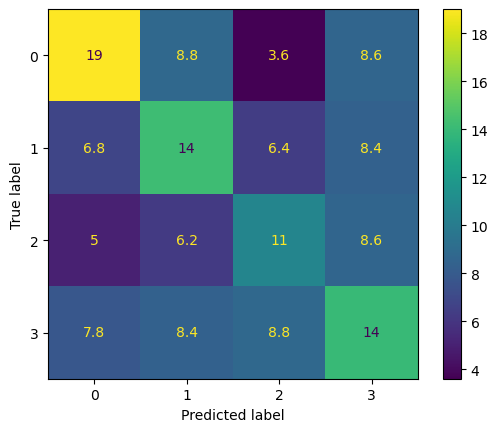

AdaBoostClassifier(n_estimators=1000)


              precision    recall  f1-score   support

           0       0.81      0.58      0.68        43
           1       0.59      0.81      0.68        32

    accuracy                           0.68        75
   macro avg       0.70      0.70      0.68        75
weighted avg       0.71      0.68      0.68        75

Mean validation acc: 0.410533774208786


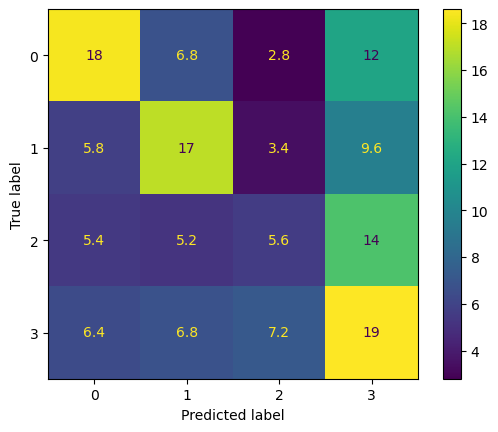

In [38]:
for clf in classifiers.values(): 
    print(str(clf)+"\n\n") 
    clf.fit(selected_X_train_standardized,selected_y_train) 
    selected_predictions=clf.predict(selected_X_test_standardized) 
    confusion_matrix = metrics.confusion_matrix(selected_y_test, selected_predictions) 
    report=metrics.classification_report(selected_y_test, selected_predictions) 
    print(report) 
    truelabels, predictlabels, cm, val_a=[], [], [], [] 
    for traini, testi in selected_kfold.split(X,y): 
        xtrain, xtest=X[traini], X[testi] 
        ytrain, ytest=y[traini], y[testi] 

        clf.fit(xtrain, ytrain) 
        p=clf.predict(xtest) 

        truelabels.extend(ytest) 
        predictlabels.extend(p) 
        val_a.append(metrics.accuracy_score (ytest,p)) 
        cm.append(metrics.confusion_matrix(ytest,p)) 
    print("Mean validation acc: "+str(np.mean(val_a))) 
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = sum(cm)/len(cm)) 
    cm_display.plot() 
    plt.show()

Support Vector Classifiers using LinearSVC such that parameter 𝐶 = 0.1, 1, 10, 100 and other parameters set as default.

In [39]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming histograms and labels are preprocessed and standardized as X and y respectively
# Example: X = standardized histograms, y = corresponding labels

# Define the values for parameter C
C_values = [0.1, 1, 10, 100]

# Initialize results dictionary
results_standard = {C: [] for C in C_values}
results_stratified = {C: [] for C in C_values}

# Perform standard 5-fold cross-validation for each C value
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for C in C_values:
    model = LinearSVC(C=C, max_iter=10000)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    results_standard[C] = scores
    print(f"Standard 5-fold CV | C={C} | Mean Accuracy: {np.mean(scores):.4f} | Std Dev: {np.std(scores):.4f}")

# Perform stratified 5-fold cross-validation for each C value
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for C in C_values:
    model = LinearSVC(C=C, max_iter=10000)
    stratified_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    results_stratified[C] = stratified_scores
    print(f"Stratified 5-fold CV | C={C} | Mean Accuracy: {np.mean(stratified_scores):.4f} | Std Dev: {np.std(stratified_scores):.4f}")


Standard 5-fold CV | C=0.1 | Mean Accuracy: 0.3000 | Std Dev: 0.0264
Standard 5-fold CV | C=1 | Mean Accuracy: 0.3586 | Std Dev: 0.0286
Standard 5-fold CV | C=10 | Mean Accuracy: 0.3897 | Std Dev: 0.0320
Standard 5-fold CV | C=100 | Mean Accuracy: 0.3879 | Std Dev: 0.0299
Stratified 5-fold CV | C=0.1 | Mean Accuracy: 0.3121 | Std Dev: 0.0127
Stratified 5-fold CV | C=1 | Mean Accuracy: 0.3672 | Std Dev: 0.0410
Stratified 5-fold CV | C=10 | Mean Accuracy: 0.3862 | Std Dev: 0.0158
Stratified 5-fold CV | C=100 | Mean Accuracy: 0.3914 | Std Dev: 0.0339


#### Comment about (1) the model complexity for SVM in relation to 𝐶, and (2) when/whether there is overfitting/underfitting.
The model is under fitting  because the training data is not necessarily the same as the test and the accuracy is low and the standard deviation is not very good 

• Plot a graph (x-axis: 𝐶; y-axis: mean validation/training error (%)) containing four error curves (2 validation error curves and 2 training error curves - label them clearly using a legend to define the curves).

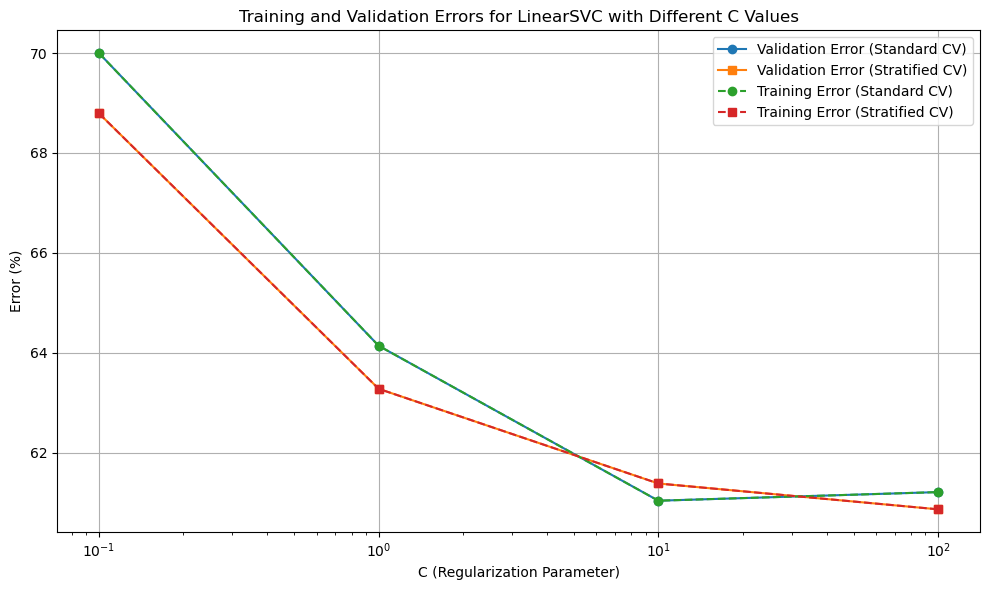

In [46]:
import matplotlib.pyplot as plt

# Store mean validation and training errors
train_errors_standard = []
val_errors_standard = []
train_errors_stratified = []
val_errors_stratified = []

# Perform cross-validation and calculate errors
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for C in C_values:
    # Standard cross-validation
    model_standard = LinearSVC(C=C, max_iter=10000)
    val_scores_standard = cross_val_score(model_standard, X_train, y_train, cv=kf, scoring='accuracy')
    train_scores_standard = cross_val_score(model_standard, X_train, y_train, cv=kf, scoring='accuracy')
    val_errors_standard.append(1 - np.mean(val_scores_standard))
    train_errors_standard.append(1 - np.mean(train_scores_standard))

    # Stratified cross-validation
    model_stratified = LinearSVC(C=C, max_iter=50000)
    val_scores_stratified = cross_val_score(model_stratified, X_train, y_train, cv=skf, scoring='accuracy')
    train_scores_stratified = cross_val_score(model_stratified, X_train, y_train, cv=skf, scoring='accuracy')
    val_errors_stratified.append(1 - np.mean(val_scores_stratified))
    train_errors_stratified.append(1 - np.mean(train_scores_stratified))

# Plotting
plt.figure(figsize=(10, 6))

# Validation error curves
plt.plot(C_values, np.array(val_errors_standard) * 100, label='Validation Error (Standard CV)', marker='o')
plt.plot(C_values, np.array(val_errors_stratified) * 100, label='Validation Error (Stratified CV)', marker='s')

# Training error curves
plt.plot(C_values, np.array(train_errors_standard) * 100, label='Training Error (Standard CV)', linestyle='--', marker='o')
plt.plot(C_values, np.array(train_errors_stratified) * 100, label='Training Error (Stratified CV)', linestyle='--', marker='s')

# Formatting the plot
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Error (%)')
plt.title('Training and Validation Errors for LinearSVC with Different C Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
print('train_errors_standard --', train_errors_standard )
print('train_errors_stratified --', train_errors_stratified)
print('val_errors_standard --', val_errors_standard)
print('val_errors_stratified --', val_errors_stratified)


train_errors_standard -- [0.7, 0.6413793103448275, 0.6103448275862069, 0.6120689655172413]
train_errors_stratified -- [0.6879310344827586, 0.6327586206896552, 0.6137931034482759, 0.6086206896551725]
val_errors_standard -- [0.7, 0.6413793103448275, 0.6103448275862069, 0.6120689655172413]
val_errors_stratified -- [0.6879310344827586, 0.6327586206896552, 0.6137931034482759, 0.6086206896551725]


In [44]:
val_errors_standard

[0.7, 0.6413793103448275, 0.6103448275862069, 0.6120689655172413]

Which 𝐶 has/have the lowest mean error for each curve?

In [41]:
# Finding the C value with the lowest mean validation error
optimal_C = min(results_stratified, key=lambda c: np.mean(1 - results_stratified[c]))
print(f"Optimal C (from stratified 5-fold CV): {optimal_C}")
# Finding the C value with the lowest mean validation error
optimal_stan = min(results_standard, key=lambda c: np.mean(1 - results_standard[c]))
print(f"Optimal C (from stratified 5-fold CV): {optimal_C}")
print('The lowest mean error for each curve', min(optimal_stan, optimal_C))

Optimal C (from stratified 5-fold CV): 100
Optimal C (from stratified 5-fold CV): 100
The lowest mean error for each curve 10


Use the 𝐶 value with the lowest mean validation error for your SVM classifier from the stratified
5-fold cross-validation. What is the error for the test dataset

In [43]:
# Train the final model with this optimal C on the entire training set
final_model = LinearSVC(C=optimal_C, max_iter=10000)
final_model.fit(X_train, y_train)

# Predict on the test dataset
y_test_pred = final_model.predict(X_test)

# Calculate test error
test_accuracy = np.mean(y_test == y_test_pred)
test_error = 1 - test_accuracy
print(f"Test Error: {test_error * 100:.2f}%")


Test Error: 58.22%
